In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.a) Importing Libraries

In [2]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plot
%matplotlib inline

# Seaborn
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, MaxPool2D, Dropout, Flatten
from keras.layers.convolutional import Conv2D

import tensorflow as tf
from tensorflow.keras import datasets, models, layers, optimizers
from sklearn.metrics import confusion_matrix

## 1.b)  Import image and label data

In [3]:
# import npy file to read the image data
imageData = np.load("/content/drive/MyDrive/Colab Notebooks/Project_7/images.npy")

#import the label file
label = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_7/Labels.csv")

## 1.c) Shapes of the data

In [4]:
# Shape and size of the images
imageData.shape

(4750, 128, 128, 3)

In [5]:
# shape and size of the labels
label.shape

(4750, 1)

 #### Print 0th Label

In [6]:
print(label.loc[0])

Label    Small-flowered Cranesbill
Name: 0, dtype: object


 ## 1.d) Visualize the images

Text(0.5, 1.0, 'Small-flowered Cranesbill')

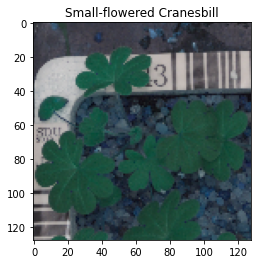

In [7]:
index = 3
plot.imshow(imageData[index], cmap='gray')
plot.title(label.loc[index].Label)

Text(0.5, 1.0, 'Fat Hen')

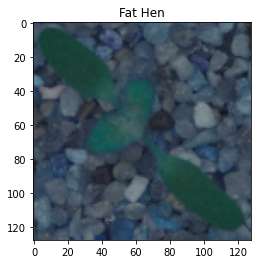

In [8]:
index = 800
plot.imshow(imageData[index], cmap='gray')
plot.title(label.loc[index].Label)


Text(0.5, 1.0, 'Shepherds Purse')

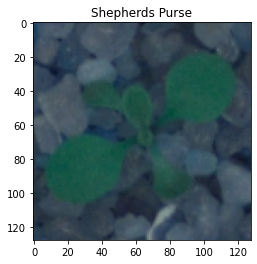

In [9]:
index = 1100
plot.imshow(imageData[index], cmap='gray')
plot.title(label.loc[index].Label)

# 2. Data Pre-Processing

## 2.a) Normalizing the image data

In [10]:
imageData = imageData.astype('float32')/255.0
imageData.shape

(4750, 128, 128, 3)

## 2.b) Blur the image data (Gaussian Blurring)

In [11]:
blurX = []
# Gaussian blurring
for img in imageData:
    blurImg = cv2.GaussianBlur(img,(5,5,),0)
    blurX.append(blurImg)
    
blurX = np.asarray(blurX)

## 2.c) Visualize the original (sharp) image Vs Blurred Image

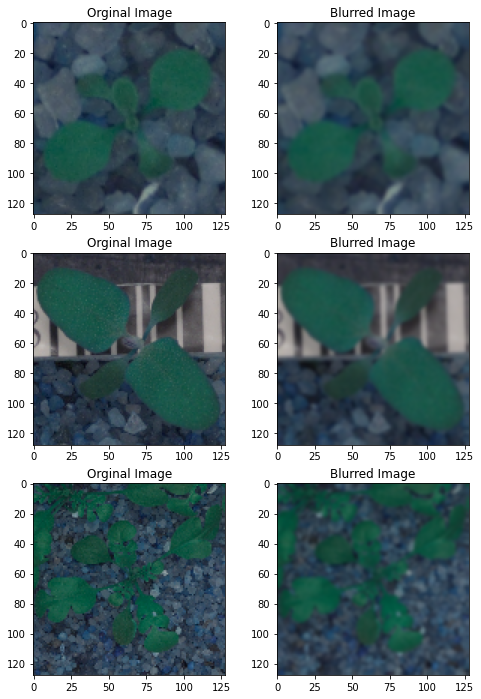

In [12]:
fix, axarr = plot.subplots(3,2, figsize=(8,12))

axarr[0,0].imshow(imageData[index])
axarr[0,0].title.set_text("Orginal Image")

axarr[0,1].imshow(blurX[index])
axarr[0,1].title.set_text("Blurred Image")

index = 500
axarr[1,0].imshow(imageData[index])
axarr[1,0].title.set_text("Orginal Image")

axarr[1,1].imshow(blurX[index])
axarr[1,1].title.set_text("Blurred Image")

index = 1200
axarr[2,0].imshow(imageData[index])
axarr[2,0].title.set_text("Orginal Image")

axarr[2,1].imshow(blurX[index])
axarr[2,1].title.set_text("Blurred Image")


#### Value count of the labels

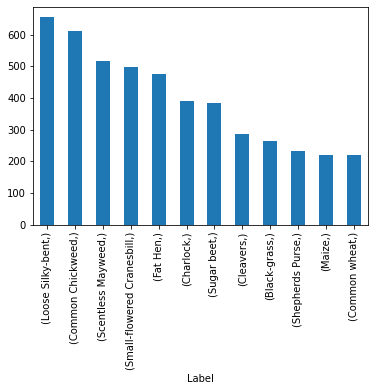

In [13]:
# Value count y labels
label.value_counts().plot(kind='bar')

# Making Data Compatible

## 3.a) One Hot Encoder to convert the labels

In [14]:
# Converting labels to one hot vector
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
YLabels = enc.fit_transform(label)

## 3.b) Show fews of the labels after one hot encoding

In [15]:
# 3.b Print label for y[0]
print("Name = " + label.loc[0].Label )
print(" One hot vector = ", YLabels[0])

Name = Small-flowered Cranesbill
 One hot vector =  [0 0 0 0 0 0 0 0 0 0 1 0]


In [16]:
print("Name = " + label.loc[2100].Label )
print(" One hot vector = ", YLabels[2100])

print("Name = " + label.loc[2700].Label )
print(" One hot vector = ", YLabels[2700])

print("Name = " + label.loc[1600].Label )
print(" One hot vector = ", YLabels[1600])

print("Name = " + label.loc[3060].Label )
print(" One hot vector = ", YLabels[3060])

Name = Charlock
 One hot vector =  [0 1 0 0 0 0 0 0 0 0 0 0]
Name = Cleavers
 One hot vector =  [0 0 1 0 0 0 0 0 0 0 0 0]
Name = Common Chickweed
 One hot vector =  [0 0 0 1 0 0 0 0 0 0 0 0]
Name = Scentless Mayweed
 One hot vector =  [0 0 0 0 0 0 0 0 1 0 0 0]


## 3.c) Split into Train/Validation/Test data¶

In [17]:
# 3.c Splitting the data
from sklearn.model_selection import train_test_split

# Split train and test with 0.3 as test
X_train, X_test, Y_train, Y_test = train_test_split(blurX, YLabels, test_size = 0.3, random_state = 8)  

# Again split the test into test and validation with test size = 0.5
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 8) 

In [18]:
print(" X Train Length = {} and Y Train Length = {}".format(len(X_train), len(Y_train)))
print(" X Test Length = {} and Y Train Length = {}".format(len(X_test), len(Y_test)))
print(" X Validation Length = {} and Y Validation Length = {}".format(len(X_val), len(Y_val)))

 X Train Length = 3325 and Y Train Length = 3325
 X Test Length = 712 and Y Train Length = 712
 X Validation Length = 713 and Y Validation Length = 713


## 3.d) Checking shape of data and reshape if required

CNN takes the 4D array ( batchsize x height x width x depth or channel ) as input. Our XTrain data is already in the 4D shape. So we dont have to reshape it.
If the input data is a single dimension array for example if our input array is of shape (1228800, ) instead of shape (100, 64, 64, 3), then we have to reshape the array to convert it from 1D to 4D like --> input = input.reshape(100,64,64,3).

# 4. Build CNN

In [19]:
from keras.models import Sequential

seed =5
np.random.seed(seed)
tf.random.set_seed(seed)

model = Sequential()

# CNN Block1
model.add(Conv2D(128, (5, 5), padding='same', activation="relu", input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

# CNN Block2
model.add(Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.15))

# CNN Block3
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.2))

# Flatter array as dense layer takes vector as input
model.add(Flatten())

# dense layer1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

#dense layer2
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(12, activation='softmax'))


## 4.b) Setting Optimizer and loss function


In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     9728      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

## 5.a ) Fit the model with training data

In [21]:
history = model.fit(X_train,Y_train,batch_size=128,epochs=100,verbose=1,validation_data=(X_val, Y_val))

Epoch 1/100
26/26 [==============================] - 11s 302ms/step - loss: 2.8707 - accuracy: 0.1783 - val_loss: 2.7706 - val_accuracy: 0.0813
Epoch 2/100
26/26 [==============================] - 6s 227ms/step - loss: 1.7078 - accuracy: 0.4378 - val_loss: 6.8449 - val_accuracy: 0.0435
Epoch 3/100
26/26 [==============================] - 6s 228ms/step - loss: 1.3337 - accuracy: 0.5621 - val_loss: 6.4641 - val_accuracy: 0.0407
Epoch 4/100
26/26 [==============================] - 6s 228ms/step - loss: 1.0658 - accuracy: 0.6401 - val_loss: 7.1321 - val_accuracy: 0.0421
Epoch 5/100
26/26 [==============================] - 6s 230ms/step - loss: 0.8599 - accuracy: 0.7124 - val_loss: 4.7349 - val_accuracy: 0.1010
Epoch 6/100
26/26 [==============================] - 6s 230ms/step - loss: 0.7039 - accuracy: 0.7737 - val_loss: 6.5334 - val_accuracy: 0.0631
Epoch 7/100
26/26 [==============================] - 6s 229ms/step - loss: 0.6269 - accuracy: 0.7866 - val_loss: 4.9897 - val_accuracy: 0.095

## 5.b) Predict the test data

In [22]:
predY = model.predict(X_test)

## 5.c) Evaluate the model

In [23]:
print("Train       evaluate = ", model.evaluate(X_train,Y_train))
print("Validation  evaluate = ", model.evaluate(X_val,Y_val))
print("Test        evaluate = ", model.evaluate(X_test,Y_test))

104/104 [==============================] - 2s 19ms/step - loss: 0.0084 - accuracy: 0.9979
Train       evaluate =  [0.0083957863971591, 0.9978947639465332]
23/23 [==============================] - 0s 20ms/step - loss: 1.9332 - accuracy: 0.7391
Validation  evaluate =  [1.9332184791564941, 0.739130437374115]
23/23 [==============================] - 0s 16ms/step - loss: 1.9750 - accuracy: 0.7430
Test        evaluate =  [1.9749733209609985, 0.742977499961853]


In [24]:
predTestYVals = np.argmax(predY,axis=1)
TrueTestYVals = np.argmax(Y_test,axis=1)
predTestYVals.shape

(712,)

## 5.d) Confusion Matrix

In [25]:
# confusion matrix
confMtx = confusion_matrix(TrueTestYVals,predTestYVals)
confMtx

array([[ 14,   1,   0,   0,   5,   1,  22,   0,   0,   0,   0,   0],
       [  0,  42,   0,   0,   0,   1,   0,   0,   5,   4,   3,   0],
       [  0,   0,  33,   0,   3,   1,   0,   0,   1,   0,   1,   1],
       [  0,   0,   0, 102,   0,   0,   0,   0,   1,   0,   3,   0],
       [  1,   1,   2,   1,  20,   1,   5,   0,   1,   0,   0,   1],
       [  1,   0,   0,   9,   0,  47,  11,   0,   5,   1,   1,   2],
       [  3,   0,   1,   3,   2,   3,  83,   0,   0,   0,   3,   0],
       [  0,   0,   0,   4,   0,   1,   0,  19,   1,   0,   0,   0],
       [  0,   0,   1,   9,   1,   1,   0,   2,  46,   2,   0,   1],
       [  0,   0,   0,  13,   1,   0,   0,   1,   2,  15,   1,   0],
       [  0,   1,   0,   6,   0,   0,   0,   0,   0,   3,  73,   0],
       [  1,   0,   0,   5,   0,   2,   0,   3,   6,   2,   2,  35]])

## 5.e) Plot confusion matrix

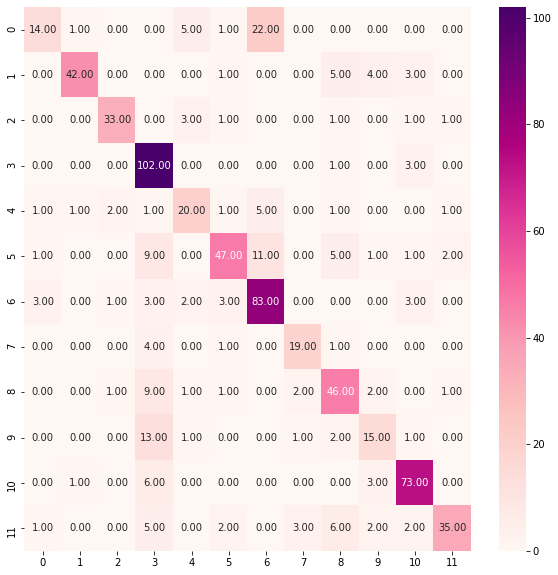

In [26]:
plot.figure(figsize=(10,10))
sns.heatmap(confMtx, annot=True,  fmt='.2f',  cmap="RdPu")

## 5.f) Print the predicted labels

In [27]:
predTestYVals

array([ 6,  3,  8,  2,  6,  3,  6, 10,  3,  2,  2,  3, 10,  0,  3, 10, 11,
       10,  8,  5,  3,  1,  8,  4,  9,  2, 10,  6,  3,  3,  9,  0,  8,  3,
        7,  3,  5,  0,  6,  7,  8,  5,  5,  9, 10,  4,  3,  1,  1,  3,  0,
        2, 10, 10,  8,  1,  8,  3,  6, 10,  2,  8,  3,  8,  5,  1,  3,  3,
        9,  5,  8,  8,  4,  8,  8,  3,  8,  5,  6,  4,  7, 11,  6,  2,  3,
        5,  5,  6,  5,  5,  1, 10,  1,  4,  5,  2,  6,  3,  8,  8,  6,  8,
        3,  6,  6,  7,  0,  1,  8,  2,  5,  2,  3, 10,  3,  3,  5,  5,  3,
       11,  6, 10,  5,  2,  5,  7,  2, 10,  3,  2,  6, 10,  5,  3,  5,  8,
        3, 11,  0,  1, 10,  3,  4,  6,  3,  3,  6,  5,  6,  9,  3, 11,  3,
        6,  5, 10, 10, 11,  6, 10,  3,  6,  3, 11,  6, 10,  6,  0,  8,  4,
        3, 11, 10,  2,  3,  2,  8,  3,  3,  6,  5,  8,  0,  3,  7,  3, 10,
        6,  4,  5,  6,  3,  1, 10, 10,  4,  1, 10,  3,  6,  6,  7,  3,  3,
        2,  8,  5,  3,  6,  6,  4,  3,  3,  5,  0,  8,  6, 11,  3,  4,  2,
        5,  3,  6, 11,  8

In [28]:
labelNames = set(label["Label"])
labelNames = list(labelNames)
labelNames.sort()

# 6. Visualize the predictions

In [29]:
def PlotPredict(idx):
  plot.figure(figsize=(15,10))
  plot.imshow(X_test[idx], cmap = 'gray')

  # predicted class name
  predClass = predTestYVals[idx]
  predClassLabel = labelNames[predClass]

  # True class name
  trueClass = TrueTestYVals[idx]
  trueClassLabel = labelNames[trueClass]

  title = "True = {} <--------> Pred = {}".format(trueClassLabel,predClassLabel)
  plot.title(title)

### Visualize some of the predicted images 

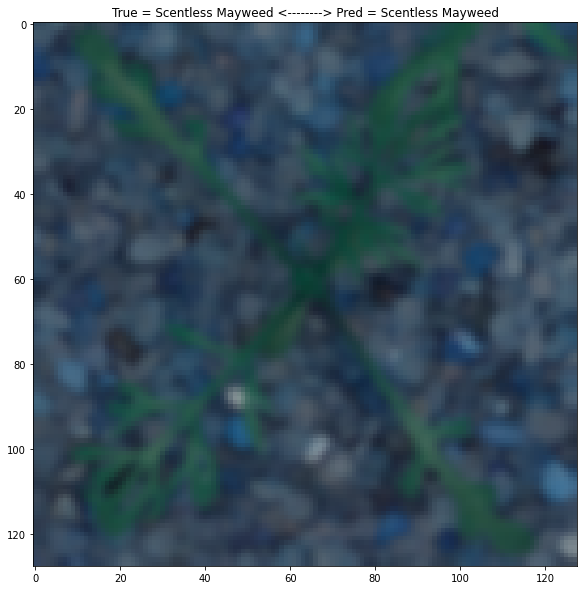

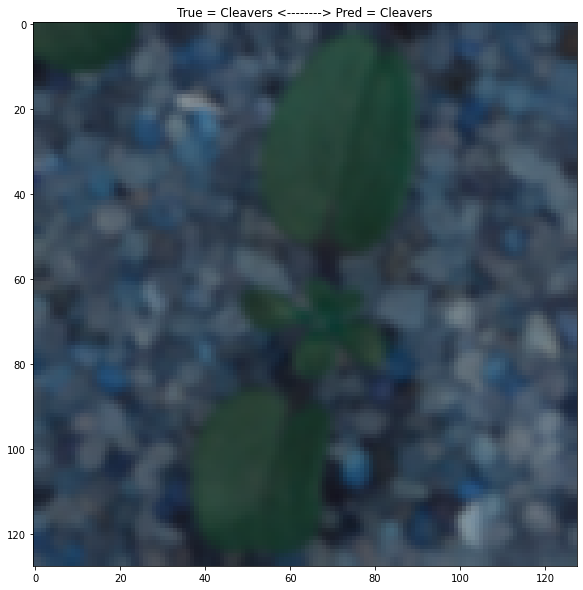

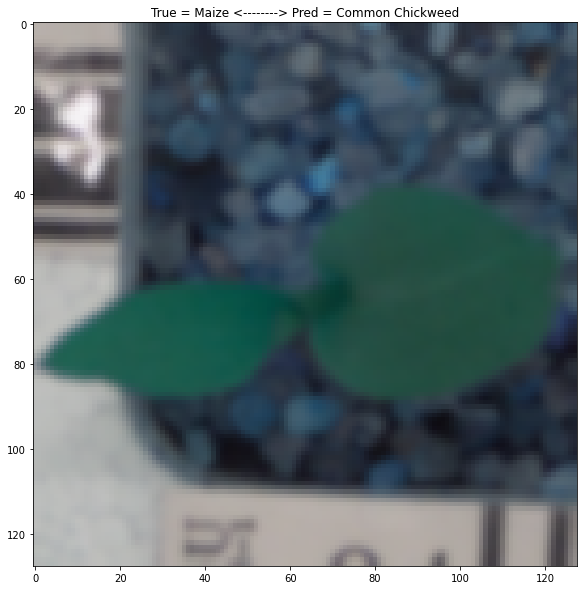

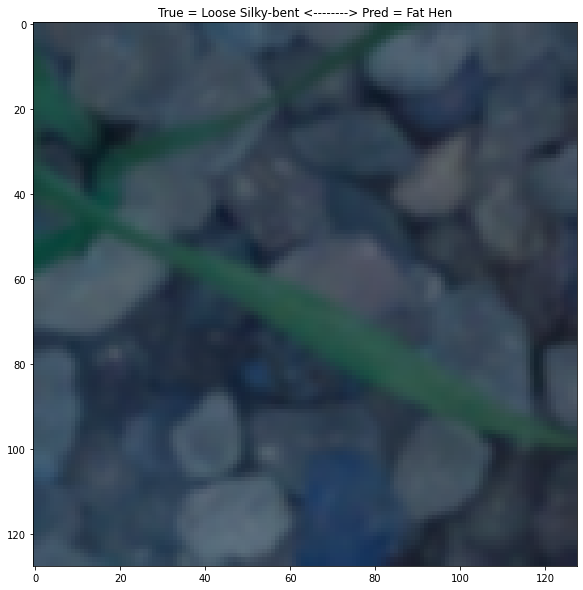

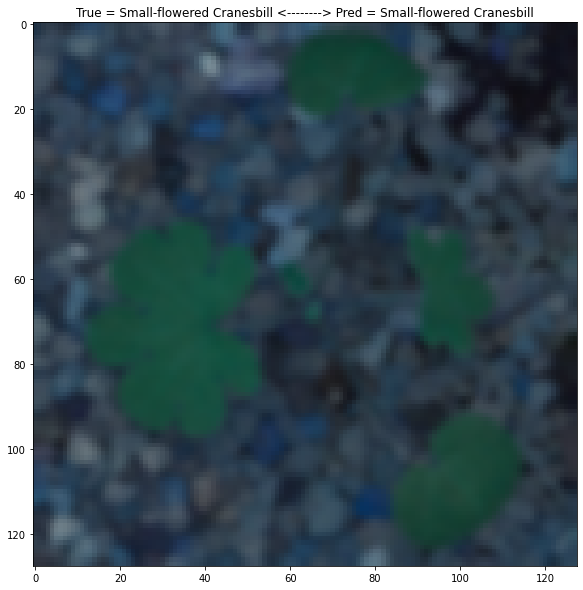

In [30]:
PlotPredict(2)
PlotPredict(3)
PlotPredict(33)
PlotPredict(36)
PlotPredict(59)


## Print Predicted And True Labels

In [31]:
results = []
for i in range (len(predTestYVals)):
    results.append((labelNames[predTestYVals[i]], labelNames[TrueTestYVals[i]]))
results_Df = pd.DataFrame(results, columns=["PredictedLabel", "TrueLabel"])
print(results_Df)

        PredictedLabel          TrueLabel
0     Loose Silky-bent   Loose Silky-bent
1     Common Chickweed   Common Chickweed
2    Scentless Mayweed  Scentless Mayweed
3             Cleavers           Cleavers
4     Loose Silky-bent        Black-grass
..                 ...                ...
707   Common Chickweed   Common Chickweed
708   Loose Silky-bent   Loose Silky-bent
709   Loose Silky-bent   Loose Silky-bent
710   Loose Silky-bent   Loose Silky-bent
711         Sugar beet            Fat Hen

[712 rows x 2 columns]
